# compute spectra on mitgcm outputs

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
dmethod = 1
#
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    # folder where data is spilled when RAM is filled up
    local_dir = os.getenv('TMPDIR')
    #
    cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                         threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                         death_timeout=100)
    w = cluster.start_workers(40)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
if dmethod == 2:
    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.47:8786 Dashboard: http://10.148.0.47:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB


--- 

# load data

In [ ]:
v = 'Eta'
face = 1

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'
# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
filenames = filenames[:2]
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset('/home1/scratch/aponte/mit_grid_t.nc')
grid = grid.isel(face=face)
print(grid)

In [7]:
#%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
%time ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')

ds = ds.isel(time=slice(0,3000))

ds = xr.merge([ds,grid])

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 103 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
  

In [8]:
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)
print(ds)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 110 ms
<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 480)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
  * time     (time) float64 2.592e+05 2.628e+05 2.664e+05 2.7e+05 2.736e+05 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (i, j) float32 dask.array<shape=(4320, 4320), chunksi

In [9]:
%time eta = ds['Eta'].persist()

CPU times: user 1.88 s, sys: 48 ms, total: 1.92 s
Wall time: 1.93 s


---

# spectral computations 

In [10]:
v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False).mean(dim=('i','j'))
E = E.astype('f8').rename('eta_power_spectrum ()')

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:


In [11]:
%time E.load()

CPU times: user 23.6 s, sys: 264 ms, total: 23.9 s
Wall time: 3min 12s


<xarray.DataArray 'eta_power_spectrum ()' (freq_time: 480)>
array([5.928565e-10, 1.403779e+02, 2.312437e+02, ..., 8.740686e+01,
       2.312437e+02, 1.403779e+02])
Coordinates:
  * freq_time          (freq_time) float64 0.0 5.787e-07 1.157e-06 1.736e-06 ...
    freq_time_spacing  float64 5.787e-07

No handles with labels found to put in legend.


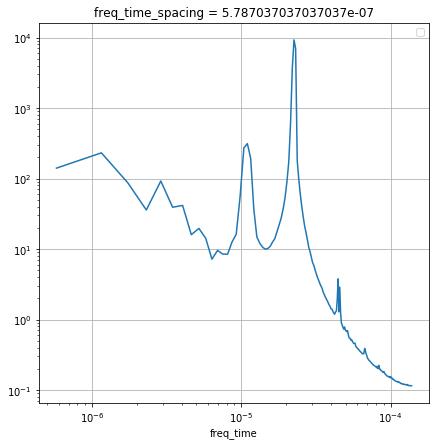

In [13]:
# and plot
fig, ax = plt.subplots(figsize=(7,7))
E.where(E.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 
#ax.set_ylim([1e-1,1e5])

---

In [13]:
client.restart()

Client Scheduler: tcp://10.148.0.44:8786 Dashboard: http://10.148.0.44:8787/status,Cluster Workers: 7 Cores: 98 Memory: 700.00 GB
